# 3. Random Forest and XGBoost Modeling

## Project Goal
Building on our baseline model, our goal in this notebook is to train and evaluate more advanced **ML models**—specifically **Random Forest** and **XGBoost**—to improve our **churn prediction** accuracy and ultimately enhance the business **impact** of our insights. We will also introduce a robust **end-to-end ML pipeline** for future deployment.

---

## 3.1 Data Preparation

Unlike our baseline model, tree-based models like Random Forest are not sensitive to ordinal relationships. Therefore, we will use **Label Encoding** for our categorical features, which is simpler and often works well with these models.

Our data preparation steps will include:
-   **Applying Label Encoding** to all categorical features.
-   **Splitting the data** into training and testing sets.

---

## 3.2 Random Forest Model

We'll begin by building a Random Forest model, a powerful algorithm known for its high accuracy.

-   **Model Training and Evaluation:** We will train an initial Random Forest model and evaluate its performance on the test set to see if it outperforms our Logistic Regression baseline.
-   **Hyperparameter Tuning:** To optimize the model, we will use **RandomizedSearchCV** to efficiently search for the best combination of hyperparameters (e.g., number of estimators, max depth).
-   **Training with Tuned Parameters:** We will train a new Random Forest model using the best hyperparameters found during the tuning process.
-   **Feature Importance:** We will analyze the **feature importance** scores from the tuned model to identify which variables are most predictive of customer churn. This provides crucial insights for the business.

---

## 3.3 Feature Engineering and Comparison

Based on the feature importance analysis, we'll perform a final round of **feature engineering** by either dropping the least important features or creating new ones to see if it further improves model performance.

-   **XGBoost Model:** We will train an **XGBoost model** with similar hyperparameter tuning to compare its performance against our optimized Random Forest model. This will help us determine which algorithm is the best for our final solution.

---

## 3.4 Creating and Saving the ML Pipeline

To ensure our model is ready for a reproducible and scalable **deployment**, we will create a complete **end-to-end ML pipeline**.

-   **Pipeline Components:** The pipeline will include all the necessary steps: feature engineering, encoding, and the final tuned Random Forest model.
-   **Saving the Pipeline with Joblib:** We will use **`joblib`** to serialize and save the entire pipeline to a `.pkl` file. `joblib` is often preferred over `pickle` for large NumPy arrays and objects that contain them, making it an excellent choice for machine learning models. This pickled file can then be loaded in a production environment to make predictions on new, unseen data, guaranteeing that the same preprocessing steps are applied consistently. This is a critical step for translating our **prediction** work into a functional platform with a real business **KPI**.

In [4]:
import pandas as pd
df = pd.read_csv("telco_cleaned.csv", index_col= 0)

In [5]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [6]:
df.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

### For random forest label encoding all columns as random forest does not interpret priority encoding (does not assume ordinal relationship)

In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # store encoder for later use


In [23]:
df.head()
df.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1282
           1       0.67      0.46      0.55       479

    accuracy                           0.79      1761
   macro avg       0.74      0.69      0.71      1761
weighted avg       0.78      0.79      0.78      1761

Confusion Matrix:
[[1171  111]
 [ 257  222]]
ROC-AUC Score:
0.8338069430919199


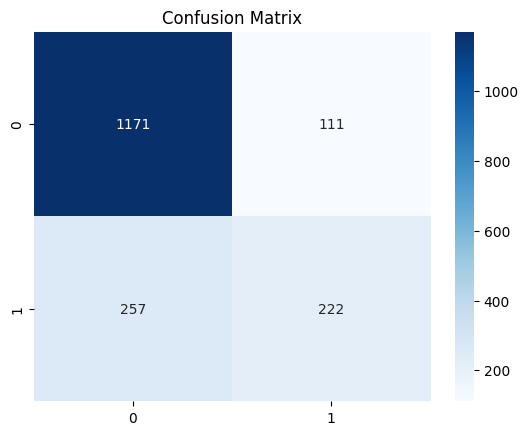

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

X = df.drop('Churn', axis=1)
y = df['Churn']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

#Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


Accuracy: 79%

ROC-AUC: 0.8338

Class 1 Recall: 46%

F1-Score (Class 1): 55%

Confusion matrix shows more false negatives (missed positives) but fewer false positives compared to Logistic Regression

### Hyper Parameter Tuning to improve result of Random Forest

In [10]:
from sklearn.model_selection import RandomizedSearchCV

# Base Random Forest model
rf = RandomForestClassifier(random_state=42)
# RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # number of parameter settings that are sampled
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    scoring='roc_auc'
)

random_search.fit(X_train, y_train)

print("Best hyperparameters:", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}


### Retraining Random Forest on the tuned hyper parameters

In [11]:
rf_best = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='log2',
    max_depth=10,
    bootstrap=True,
    random_state=42
)

# Train model
rf_best.fit(X_train, y_train)

# Predict on test set
y_pred = rf_best.predict(X_test)
y_prob = rf_best.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1282
           1       0.68      0.50      0.58       479

    accuracy                           0.80      1761
   macro avg       0.76      0.71      0.72      1761
weighted avg       0.79      0.80      0.79      1761

Confusion Matrix:
[[1169  113]
 [ 239  240]]
ROC-AUC Score:
0.8572420767394372


### Feature Importance


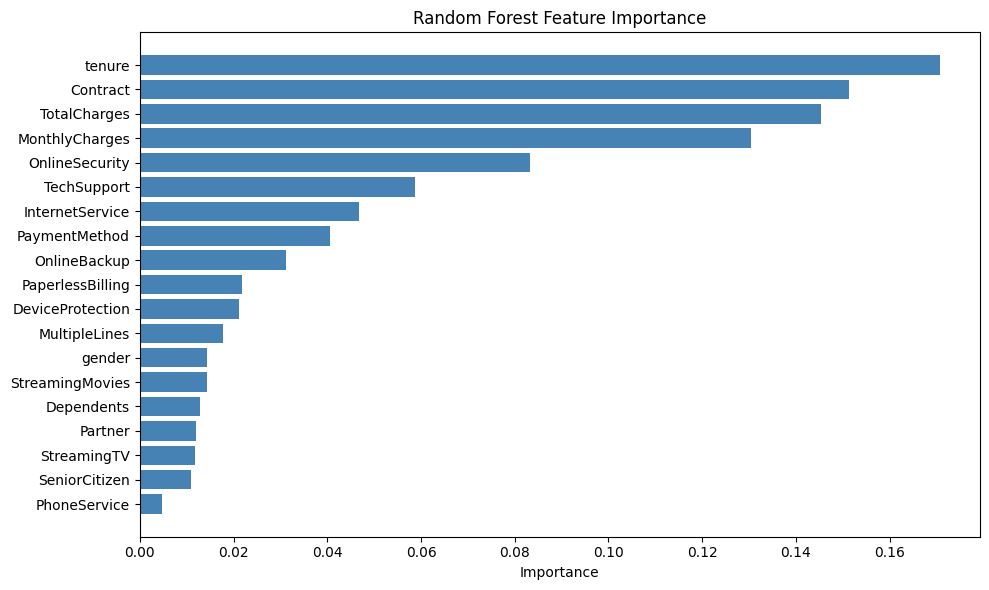

In [12]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # most important at top
plt.tight_layout()
plt.show()


### Feature Engineering based on feature importance


In [13]:
df_copy = pd.read_csv('telco_cleaned.csv', index_col=0)
df_copy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [14]:
#contract(in months) and is_month_to_month 
contract_map = {'Month-to-month': 1, 'One year': 12, 'Two year': 24}
df_copy['contract_len'] = df_copy['Contract'].map(contract_map)
df_copy['is_month_to_month'] = (df_copy['contract_len'] == 1).astype(int)
df_copy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,contract_len,is_month_to_month
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,1
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,0,12,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,12,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1,1


In [15]:
bins = [-float('inf'), 3, 6, 12, 24, 48, float('inf')]
labels = ['0-3','4-6','7-12','13-24','25-48','49+']
df_copy['tenure_bin'] = pd.cut(df_copy['tenure'], bins=bins, labels=labels)
df_copy['is_new_customer'] = (df_copy['tenure'] <= 3).astype(int)

order = ['0-3','4-6','7-12','13-24','25-48','49+'] 

df_copy['tenure_bin'] = pd.Categorical(df_copy['tenure_bin'], categories=order, ordered=True)
df_copy['tenure_bin_code'] = df_copy['tenure_bin'].cat.codes.astype('int8')


print(df_copy['tenure_bin'].cat.categories)  
print(df_copy['tenure_bin'].cat.ordered)     


Index(['0-3', '4-6', '7-12', '13-24', '25-48', '49+'], dtype='object')
True


In [16]:
df_copy['total_per_month'] = (df_copy['TotalCharges'] / df_copy['tenure']).replace([float('inf')], 0).fillna(0)

q80 = df_copy['MonthlyCharges'].quantile(0.80)
df_copy['high_monthly_flag'] = (df_copy['MonthlyCharges'] >= q80).astype(int)


Created meaningful features from raw data before encoding.

Engineered contract-based and tenure-based features:

is_month_to_month from Contract

tenure_bin (ordered buckets) and is_new_customer

total_per_month and high_monthly_flag from charges

Encoded the ordered tenure bins with pandas categorical codes:

Defined an explicit order: ['0-3','4-6','7-12','13-24','25-48','49+']

Converted tenure_bin to an ordered categorical and created tenure_bin_code via .cat.codes

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df_copy.select_dtypes(include=['object', 'category']).columns:
    df_copy[col] = le.fit_transform(df_copy[col].astype(str))

### Dropping less important features

In [18]:
df_copy = df_copy.drop(columns=["PhoneService","StreamingTV","SeniorCitizen","Partner","Dependents","StreamingMovies","gender"], axis = 1)

### Retraining model on new engineered features and tuned parameters

In [19]:

X = df_copy.drop(columns=['Churn'])
y = df_copy['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


rf_best = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='log2',
    max_depth=10,
    bootstrap=True,
    random_state=42,
    class_weight={0:1.0, 1:2.0} )


rf_best.fit(X_train, y_train)

y_pred = rf_best.predict(X_test)
y_prob = rf_best.predict_proba(X_test)[:, 1]


print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))


fi = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop feature importances:\n", fi.head(20))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1294
           1       0.59      0.68      0.63       467

    accuracy                           0.79      1761
   macro avg       0.73      0.76      0.74      1761
weighted avg       0.80      0.79      0.79      1761

Confusion Matrix:
[[1071  223]
 [ 148  319]]
ROC-AUC Score:
0.8425851152908002

Top feature importances:
 contract_len         0.106113
MonthlyCharges       0.103117
is_month_to_month    0.100359
Contract             0.099508
total_per_month      0.098753
tenure               0.092519
TotalCharges         0.089160
OnlineSecurity       0.057622
TechSupport          0.048409
tenure_bin_code      0.038333
InternetService      0.029407
PaymentMethod        0.028233
OnlineBackup         0.021311
tenure_bin           0.020834
PaperlessBilling     0.018501
DeviceProtection     0.014053
MultipleLines        0.013327
is_new_customer      0.010863
high

### XGboost Model

In [20]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X = df_copy.drop(columns=['Churn'])
y = df_copy['Churn']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=1.0,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)


model.fit(X_train, y_train)


probs = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
print("Test AUC:", auc)



Test AUC: 0.817210217475484


# Model Comparison Summary

## Metrics Overview

**Random Forest**  
- AUC: 0.8426  
- Churn Precision: 0.59  
- Churn Recall: 0.68  
- Churn F1: 0.63  
- Notes: Highest recall; good when missing churners is costly.  

**Logistic Regression**  
- AUC: 0.8426  
- Churn Precision: 0.66  
- Churn Recall: 0.56  
- Churn F1: 0.61  
- Accuracy: 0.81  
- Notes: Higher precision, more interpretable, misses more churners.  

**XGBoost (baseline, no tuning)**  
- AUC: 0.8172  
- Notes: Underperformed; tuning and imbalance handling needed.

## Recommendation

- **Primary Deployment:** Random Forest  
  - Best recall and F1 for churn; competitive AUC.  
  - Action: Choose business-aligned probability threshold and monitor precision/recall.  

- **Secondary/Shadow Model:** Logistic Regression  
  - High interpretability; useful for explanations and drift monitoring.  

- **Future Iteration:** XGBoost  
  - With early stopping, class weighting, and tuning, may match or beat RF.

## Operational Notes

- Threshold selection: Optimize for class-1 F1 or target recall/precision.  
- Stability: Validate with stratified K-fold CV (report mean±std).  
- Calibration: Apply if using probabilities for prioritization.  
- Monitoring: Track data drift, set retraining triggers, maintain rollback plan.


### Storing Engineered featured in a function


### Pickling Tuned Random Forest , encoder and Engineered Features

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

# ============================
# Custom Feature Engineer
# ============================
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Save q80 threshold for consistency across train/test
        self.q80 = X['MonthlyCharges'].quantile(0.80)
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # tenure bins
        bins = [-float('inf'), 3, 6, 12, 24, 48, float('inf')]
        labels = ['0-3','4-6','7-12','13-24','25-48','49+']
        X['tenure_bin'] = pd.cut(X['tenure'], bins=bins, labels=labels)
        X['is_new_customer'] = (X['tenure'] <= 3).astype(int)

        # ordered categorical codes
        order = ['0-3','4-6','7-12','13-24','25-48','49+']
        X['tenure_bin'] = pd.Categorical(X['tenure_bin'], categories=order, ordered=True)
        X['tenure_bin_code'] = X['tenure_bin'].cat.codes.astype('int8')

        # engineered numeric features
        X['total_per_month'] = (X['TotalCharges'] / X['tenure']).replace([np.inf], 0).fillna(0)
        X['high_monthly_flag'] = (X['MonthlyCharges'] >= self.q80).astype(int)

        return X

df = pd.read_csv("telco_churn_sample_50.csv")

# Target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
y = df['Churn']
X = df.drop('Churn', axis=1)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature groups
numeric_features = [
    'tenure', 'MonthlyCharges', 'TotalCharges', 
    'tenure_bin_code', 'is_new_customer', 
    'total_per_month', 'high_monthly_flag'
]

categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
categorical_features = [col for col in categorical_features if col != 'customerID']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ],
    remainder='drop'
)

# Model
rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='log2',
    max_depth=10,
    bootstrap=True,
    random_state=42,
    class_weight={0:1.0, 1:2.0}
)

# Full Pipeline
pipeline = Pipeline(steps=[
    ('fe', FeatureEngineer()),          
    ('preprocess', preprocessor),       
    ('model', rf_model)   
])

# Fit
pipeline.fit(X_train, y_train)

print("Train Score:", pipeline.score(X_train, y_train))
print("Test Score:", pipeline.score(X_test, y_test))

# Save model
joblib.dump(pipeline, "rf_churn_pipeline.pkl")
print("Model saved!")


Train Score: 0.725
Test Score: 0.7
Model saved!
